In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2


cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: Error requiring `StaticArrays` from `ArrayInterface`
│   exception = (ErrorException("too many parameters for type"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000068f84117, Ptr{Nothing} @0x0000000068ff06a9, Ptr{Nothing} @0x000000006901236c, Ptr{Nothing} @0x0000000069012031, Ptr{Nothing} @0x0000000069012b40, Ptr{Nothing} @0x0000000069013515, Base.InterpreterIP in top-level CodeInfo for ArrayInterface at statement 82, Ptr{Nothing} @0x0000000069030c9d, Ptr{Nothing} @0x000000006903241a, Ptr{Nothing} @0x000000003b97449f, Ptr{Nothing} @0x000000003b9744c3, Ptr{Nothing} @0x000000003b959de1, Ptr{Nothing} @0x000000003b9743ea, Ptr{Nothing} @0x000000003b974413, Ptr{Nothing} @0x000000003b959748, Ptr{Nothing} @0x000000003b974351, Ptr{Nothing} @0x000000003b974383, Ptr{Nothing} @0x000000003b95533e, Ptr{Nothing} @0x000000003b95c2a4, Ptr{Nothing} @0x000000003b95c5c3, Ptr{Nothing} @0x0000000069030130, Ptr{Nothing} @0x0000000069026590, Ptr{Nothing} @0x000000001a0fa107, Ptr{No

In [9]:
using Plots
gr()  

┌ Error: Failed to revise C:\Users\liyux\.julia\packages\JuliaFormatter\n6Lz2\src\options.jl
│   exception = Revise.ReviseEvalException("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\util.jl:459", ErrorException("invalid redefinition of constant Options"), Any[(top-level scope at util.jl:459, 1)])
└ @ Revise C:\Users\liyux\.julia\packages\Revise\3RMhb\src\packagedef.jl:714
┌ Error: Failed to revise C:\Users\liyux\.julia\packages\CommonMark\Cmk5S\src\parsers\blocks.jl
│   exception = Revise.ReviseEvalException("C:\\Users\\liyux\\.julia\\packages\\CommonMark\\Cmk5S\\src\\parsers\\blocks.jl:29", ErrorException("invalid redefinition of type Parser"), Any[(top-level scope at blocks.jl:29, 1)])
└ @ Revise C:\Users\liyux\.julia\packages\Revise\3RMhb\src\packagedef.jl:714
┌ Error: Failed to revise C:\Users\liyux\.julia\packages\Tokenize\FGrTw\src\utilities.jl
│   exception = (LoadError("C:\\Users\\liyux\\.julia\\packages\\Tokenize\\FGrTw\\src\\utilities.jl", 359, Unde

Plots.GRBackend()

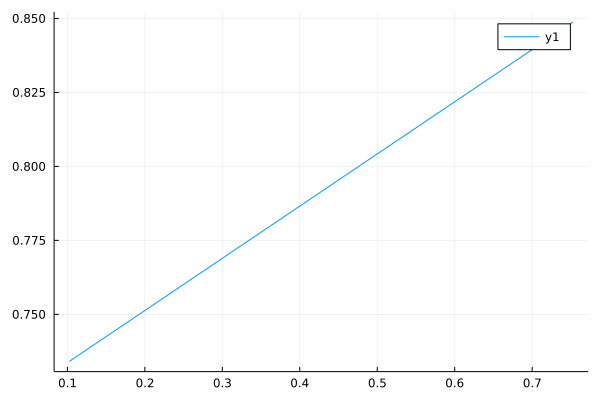

In [10]:
plot(rand(2),rand(2))

## turned on boiling, plate thickness=1mm, Hliquid = Hvapor = 1/100 original

# the plate code initialization

### Physical parameters

In [11]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
# d = 2e-3;
d = 1e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.001)

### Geometry parameters

In [12]:
inch = 2.54e-2;
Lx = 0.1524;
Ly = 0.0648;

In [13]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [14]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Te = RigidTransform((0.7inch,-0.0),0.0)
Te(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Te = RigidTransform((-0.7inch,-0.0),0.0)
Te(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tc = RigidTransform((-2.5inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tc = RigidTransform((2.5inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 1500.0
Tc = 0.0

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

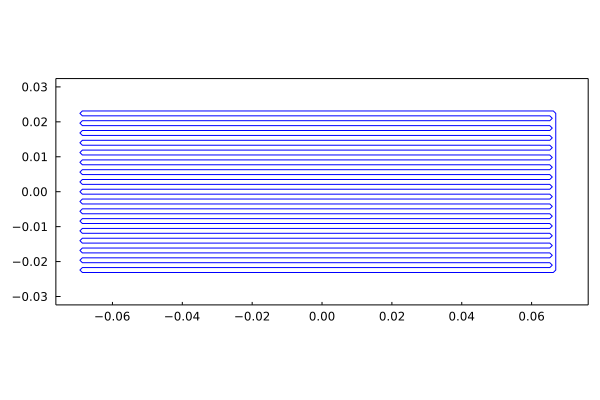

In [18]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = 46.25*1e-3
height = 133.83*1e-3
gap = d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)


In [19]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [20]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


### Initialize state, and create the integrator

In [21]:
u0 = newstate(sys)
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator);

### Set up values for the OHP heat flux per unit length and advance the solution

In [22]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


### Time marching

In [23]:
num = 1000
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

 12.942640 seconds (2.93 M allocations: 13.255 GiB, 9.46% gc time)


In [24]:
typeof(sys.qline[1].arccoord)

ScalarData{5598,Float64,Array{Float64,1}}

### Plotting temperature contours

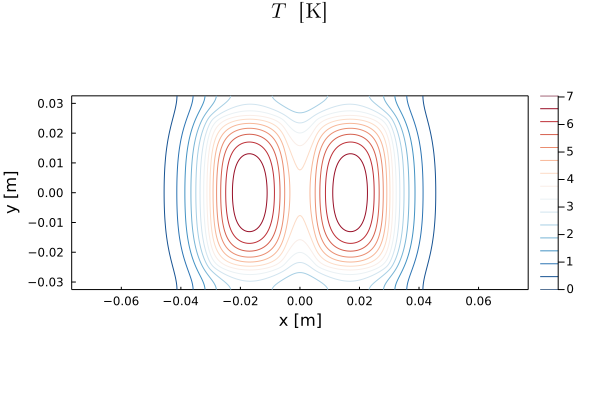

In [25]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

### Plot the temperature along the OHP channel

In [26]:
# plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [27]:
nondi_Q_to_Q = 1.35E+02
t_to_nondi_t = 2.83E-01
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [28]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
#     Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hₗ   =  1.01E+03; # liquid wall heat transfer coeffcient for static fluids
    Hδ  = 4.65E+02;


# use a smaller heat  transfer coefficient for the tube because it contacts the plate with one side.
    Hₗ = Hₗ/100 # liquid wall heat transfer coeffcient for static fluids
    Hδ = Hδ/100 # vapor film heat transfer coeffcient * thickness for static fluids

4.65

In [29]:
    d = 6.56e-3 # dimensionless diameter
    L = 34.35  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    ΔTthres = 1.0/295.0; # use a small threshold
    closedornot = true

true

In [30]:
    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [31]:
tube = Tube(d,L,L2D,angle,ΔTthres,closedornot);

In [32]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [33]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [56]:
X0,realratio = randomXp(L,numofslugs=40,chargeratio=0.45)

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)



realratio

0.4761410814692904

In [57]:
N=numpts(ohp)

ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [58]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
# Hδ = 4.64E+02
P = 0*zeros(length(X0)) .+ 1.0;
δ = 0*zeros(length(X0)) .+ 2.78E-02;
# δ = 0*zeros(length(X0)) .+ 2.78E-02 .* 10; # use a random film thickness
vapors=Vapor(γ,Hδ,P,δ);

In [59]:
α = 1.154e-5 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
# Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [60]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [61]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [62]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [63]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [64]:
tspan = (0.0, 1.0);
dt_record = tspan[2] /10;

tstep=2e-3

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [65]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
Tplate = temperature(integrator_plate);

In [66]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep*t_to_nondi_t, callback=cbst);

In [67]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

In [68]:
# integrator_plate = plate_hist[end-3]
# integrator_tube = tube_hist[end-3]

# currentsys = integrator_tube.p
# currentsys = getcurrentsys(integrator_tube.u,currentsys);

# tspan = (integrator_plate.t, integrator_plate.t + 1.0);
# dt_record = 0.01

In [69]:
# tspan = (integrator_plate.t, integrator_plate.t + 0.2);
# dt_record = tstep

In [70]:

@time for t in tspan[1]:tstep:tspan[2]
    

#   for j in 1:N_iter
        currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
        currentsys = getcurrentsys(integrator_tube.u,currentsys)


        nondi_qtmp = sys_to_heatflux(currentsys)
        qtmp = nondi_Q_to_Q*nondi_qtmp
        set_linesource_strength!(sys,qtmp)


        Tplate = ADI_timemarching!(Tplate,sys,tstep)
#     end
    integrator_plate.t += tstep
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep*t_to_nondi_t);
#     step!(integrator_tube);
    step!(integrator_tube,tstep*t_to_nondi_t,true);

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.10000000000000007
0.20000000000000015
0.3000000000000002
0.4000000000000003
Boiled! at 26.63259554252304 on 0.5000000000000003
0.5000000000000003
0.6000000000000004
0.7000000000000005
0.8000000000000006
0.9000000000000007
1.0000000000000007
 51.925111 seconds (67.40 M allocations: 46.892 GiB, 11.34% gc time)


In [71]:
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)

1.0020000000000007


In [72]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [73]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

In [74]:
maximum(temperature(plate_hist[end])[:])

1.616233438403981

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]$: undefined symbol
\quad [\mathrm{K}]

Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
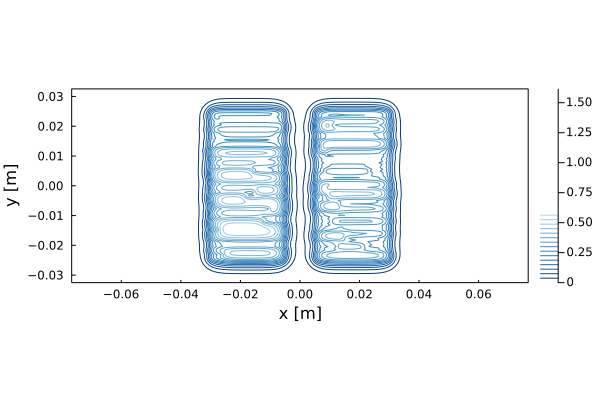

In [75]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = 0.0
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1  
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T - T0 \quad [\mathrm{K}]"))
end

In [76]:
minimum(temperature(plate_hist[end]))

0.03198966715891205

In [77]:
length(plate_hist)

11

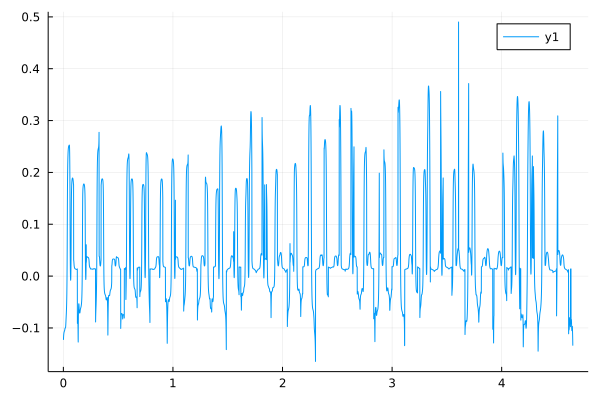

In [78]:
plot(sys.qline[1].arccoord,sys_to_heatflux(sysfinal[end]))

In [79]:
# @gif for i=1:1:1
#     Htmp = sys_to_Harray(sysfinal[i])
#     plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
# end

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
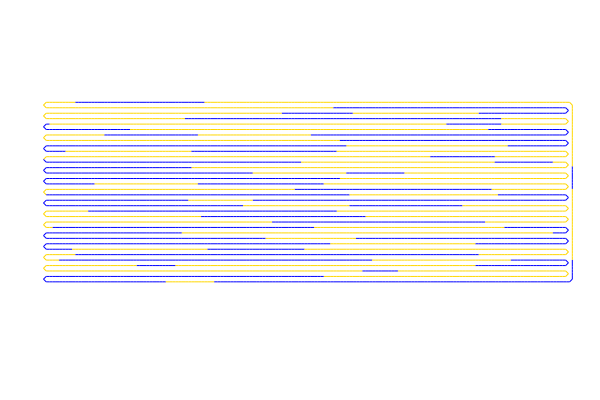

In [87]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

# plot the OHP

In [81]:
plot(sysfinal[60],xlim=(19.0,20.0),ylim=(295.0,320.0))

LoadError: [91mBoundsError: attempt to access 11-element Array{Any,1} at index [60][39m

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\LSKOd\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
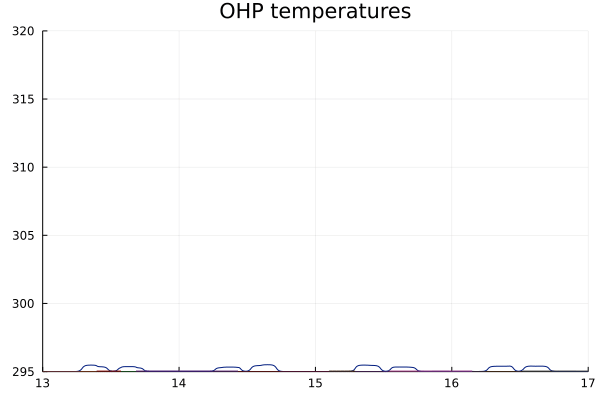

In [82]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T",xlim=(13.0,17.0),ylim=(295.0,320.0))
end

In [83]:
sysfinal[end].mapping.H_interp_liquidtowall[8.5:0.01:8.7]

21-element Array{Float64,1}:
 10.1
 10.1
 10.1
 10.1
 10.1
 10.100000000000001
 10.1
 10.1
 10.1
 10.1
 10.1
 10.1
 10.1
 10.1
 10.1
 10.1
 10.1
 10.100000000000001
 10.1
 10.1
 10.1

In [84]:
plot(sysfinal[end-30],plottype="T",xlim=(8.0,9.0))

LoadError: [91mBoundsError: attempt to access 11-element Array{Any,1} at index [-19][39m

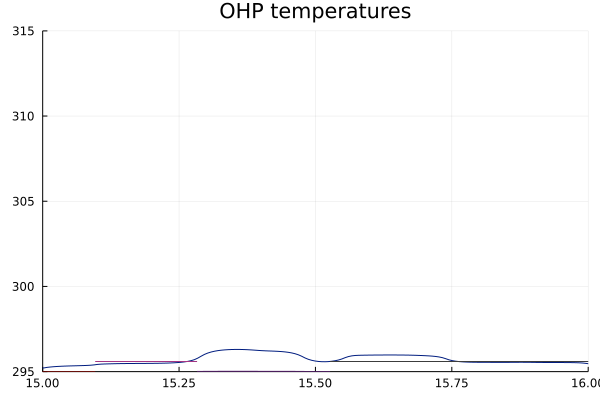

In [85]:
plot(sysfinal[end-1],plottype="T",xlim=(15.0,16.0),ylim=(295.0,315.0))

In [ ]:
plot(sysfinal[end],plottype="ΔT",ylim=(-0.1,0.1))

In [ ]:
@gif for ii=1:length(sysfinal)
    plot(sysfinal[ii],plottype="ΔT")
end

In [ ]:
# plate_hist, integrator_plate = load("plate_OHP_boiling.jld2", "plate_hist",  "integrator_plate")

In [ ]:
# tube_hist, integrator_tube = load("tube_OHP_boiling.jld2", "tube_hist",  "integrator_tube")

In [ ]:
sysfinal

In [ ]:
save("plate_OHP_mediumlowH.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [ ]:
save("tube_OHP_mediumlowH.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [ ]:
inch = 2.54e-2;

# x = [-2.7inch,0.0,2.7inch];
# y = [0.0,0.0,0.0];

x = [0.0]
y = [0.0]

X =  VectorData(x,y);

In [ ]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [ ]:
ghist = []
thist = []
for i = 1:length(plate_hist)
    H(g,temperature(plate_hist[i]))
    append!(ghist,deepcopy(g))
    append!(thist,plate_hist[i].t)
end

In [ ]:
RTDx,RTDy = load("RTD4.jld2","RTDx","RTDy")

In [ ]:
plot(thist,ghist)
scatter!(RTDx .- RTDx[1],RTDy .- RTDy[1])

In [ ]:
rand(10)